In [103]:
!pip install textaugment
!pip3 install geograpy3

In [104]:
import pandas as pd
import numpy as np
import csv
import re
import matplotlib.pyplot as plt 
import geograpy
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textaugment import EDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from nltk.tokenize import word_tokenize
import os
import pickle
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import gensim
import pickle
DATAPATH = "/content//"
TEMP_DF = "TEMP_DF.csv"

In [106]:
data_train = pd.read_csv("/content/train.csv") #Read the data

In [107]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [108]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [109]:
data_train.isnull().sum() #Check for null values

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Data Cleaning

In [110]:

max_words = 4000
tokenizer_file = 'tokenizer.pickle'

In [111]:
#import and create an EDA example
import nltk
nltk.download('stopwords')
from textaugment import EDA
t = EDA()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
#check for a place in each tweet and populate the location.
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
location_list=data_train["location"].unique() #list of all the locations in the location feature
def fill_location(sentence):
    words=sentence.split()
    location = [ loc for loc in location_list if loc in words ] #check if the tweet contains a location already present in location feature
    try:
        location=location[0]
    except:
       # location=np.nan
        places = geograpy.get_place_context(text=sentence) #check for any location in the tweet            
        countries =places.countries
        cities=places.cities
        if not countries:
            if not cities:
                location='loc'
                #print(sentence)
            else:
                location=cities[0]
                print("city found: ",location)
        else:
            location=countries[0]
            print("country found: ",location)
        if "?" in location:
            location='loc'
    return location
possible_locations = pd.DataFrame(columns = ['location']) 
possible_locations["location"]=data_train['text'].apply(fill_location)
data_train["location"].fillna(possible_locations["location"], inplace=True)#fill nan
data_train.isnull().sum()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
country found:  United States
country found:  Argentina
country found:  Philippines
country found:  Nigeria
country found:  Australia
country found:  Australia
country found:  Costa Rica
country found:  France
country found:  United States
country found:  Bahamas
country found:  South Africa
country found:  United States
country found:  United States
country found:  Bahrain
country found:  United States
country found:  Mexico
country f

id           0
keyword     61
location     0
text         0
target       0
dtype: int64

In [113]:
#replace all nan in keyword feature
keyword_list=data_train["keyword"].unique() #list all kewords in keyword feature
keyword_list = np.append(keyword_list, ['bomber','detonted','explosives','fires',
                                        'calamity','cataclysm','act of God','holocaust',
                                       'mishap','heat wave'])
def fill_keyword(sentence):
    words=sentence.split()
    keyword = [ key for key in keyword_list if key in words ] #check if any keword from keyword feature is present in tweet
    try:
        keyword=keyword[0]
    except:
        keyword='key'
    return keyword
possible_keywords = pd.DataFrame(columns = ['keyword']) 
possible_keywords["keyword"]=data_train['text'].apply(fill_keyword) 
data_train["keyword"].fillna(possible_keywords["keyword"], inplace=True)#fill nan

In [114]:
loc_dict={'United States':'USA','New York':'USA',"London":'UK',"Los Angeles, CA":'USA',"Washington, D.C.":'USA',
          "California":'USA',"Chicago, IL":'USA',"Chicago":'USA',"New York, NY":'USA',"California, USA":'USA',
          "FLorida":'USA',"Everywhere":'Worldwide',"San Francisco":'USA',"Florida":'USA',"United Kingdom":'UK',
          "Los Angeles":'USA',"Toronto":'Canada',"San Francisco, CA":'USA',"NYC":'USA',"Seattle":'USA',
          "Earth":'Worldwide',"Ireland":'UK',"London, England":'UK',"New York City":'USA',"Texas":'USA',
          "London, UK":'UK',"Atlanta, GA":'USA',"Mumbai":"India","US":"USA","us":"USA","U.S.":"USA","IN":"India"}

data_train['location'].replace(loc_dict,inplace=True)

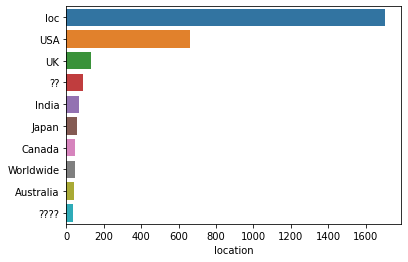

In [115]:
#plot all locations
sns.barplot(y=data_train['location'].value_counts()[:10].index,
            x=data_train['location'].value_counts()[:10],
            orient='h');

In [116]:
#replace similar key words with a single word
key_dict={'panic':'fear','suicide bomber':'bomb','suicide bomb':'bomb',
          'suicide bombing':'bomb',"mass murder":"massacre","hurricane":"typhoon"}
data_train['keyword'].replace(key_dict,inplace=True) 

In [117]:
def clean_str(txt):
    #replace and simplify a lot of signals
    txt = txt.lower()#turn to lower case
    txt = re.sub(r'http\S+', 'link', txt)
    txt = txt.replace(",000,000", "m").replace(",000","k").replace("′", "'").replace("’", "'").replace("can't", "cannot")\
             .replace("don't", "do not").replace("isn't", "is not").replace("you're", "you are").replace("you've","you have")\
             .replace("you'll", "you will").replace("that'll",'that will').replace("should've", "should have")\
             .replace("aren't", "are not").replace("couldn't", "could not").replace("didn't", "did not")\
             .replace("doesn't", "does not").replace("hadn't", "had not").replace("hasn't", "has not")\
             .replace("haven't", "have not").replace("mustn't", "must not").replace("wasn't", "was not")\
             .replace("i'm", "i am").replace("he's", "he is").replace("she's", "she is").replace("ain't", "am not")\
             .replace("%", " ").replace("₹", " rupee ").replace("$", " dollar ").replace("€", " euro ")\
             .replace("'ll", " will").replace("'ve", " have").replace("it's", "it is")
    
    txt = re.sub('[^A-Za-z]+', ' ', txt) #removing html tags
    txt = re.sub('[?|!|\'|"|#]','',txt) #removing punctuations
    txt = re.sub('[.|,|)|(|\|/]','',txt) #removing punctuations
    
    return txt

In [118]:
cleaned_str=clean_str("Horrible Accident | Man Died In Wings of AirplaneåÊ(29-07-2015) http://t.co/wq3wJsgPHL")
data_train['text'] = data_train['text'].apply(clean_str)
data_train['keyword'] = data_train['keyword'].apply(clean_str)
data_train['location'] = data_train['location'].apply(clean_str)
cleaned_str

'horrible accident man died in wings of airplane link'

In [119]:
data_train.head()

,id,keyword,location,text,target
0,1,key,usa,our deeds are the reason of this earthquake ma...,1
1,4,fire,canada,forest fire near la ronge sask canada,1
2,5,evacuation,loc,all residents asked to shelter in place are be...,1
3,6,evacuation,usa,k people receive wildfires evacuation orders ...,1
4,7,smoke,usa,just got sent this photo from ruby alaska as s...,1


In [120]:
data_train[data_train['location']==" "] ['location'].replace('loc',inplace=True)

In [121]:
data_raw_non_Disaster = data_train[data_train['target'] == 0]
data_raw_Disaster = data_train[data_train['target'] == 1]

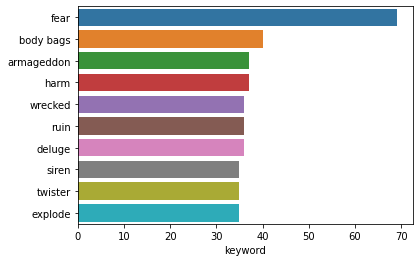

In [122]:
#plot keyword counts in non disater tweets
sns.barplot(y=data_raw_non_Disaster['keyword'].value_counts()[:10].index,
            x=data_raw_non_Disaster['keyword'].value_counts()[:10],
            orient='h');

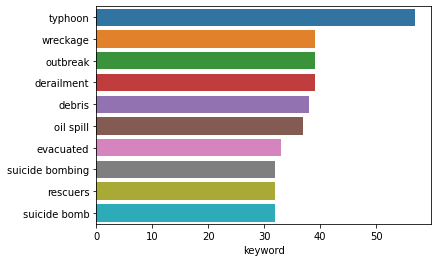

In [123]:
#plot keyword counts in disater tweets
sns.barplot(y=data_raw_Disaster['keyword'].value_counts()[:10].index,
            x=data_raw_Disaster['keyword'].value_counts()[:10],
            orient='h');

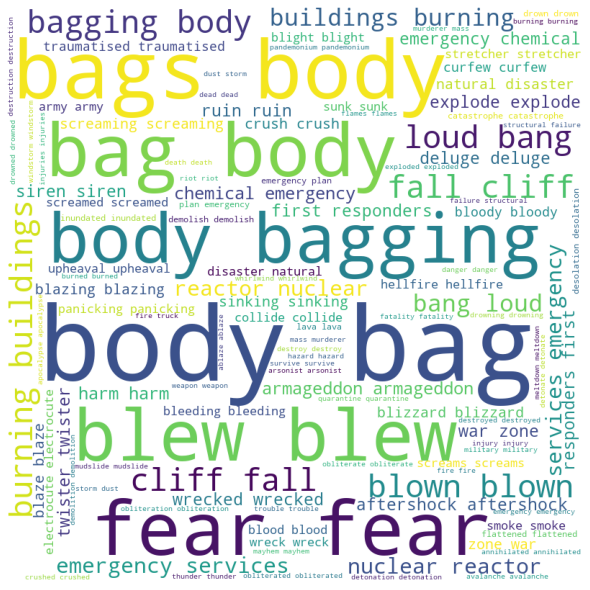

In [124]:
words = '' 
for val in data_raw_non_Disaster["keyword"]:
     val = str(val) 
  
    # split the value 
     tokens = val.split() 
      
    # Converts each token into lowercase 
     for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
        words += " ".join(tokens)+" "


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(words) 
  
# plot the keyword WordCloud image for non disaster tweets                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

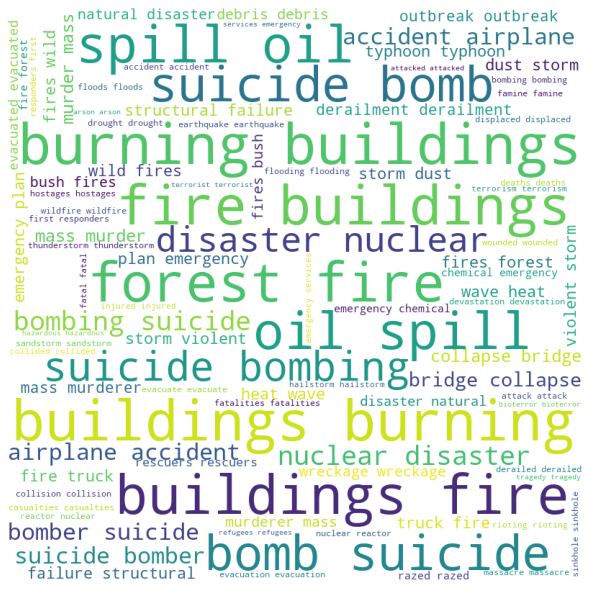

In [125]:
words = '' 
for val in data_raw_Disaster["keyword"]:
     val = str(val) 
  
    # split the value 
     tokens = val.split() 
      
    # Converts each token into lowercase 
     for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
        words += " ".join(tokens)+" "


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(words) 
  
# plot the keyword WordCloud image for disaster tweets                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

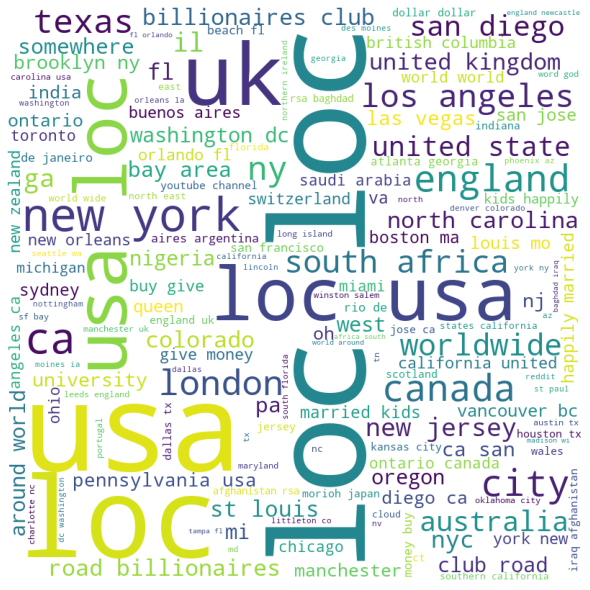

In [126]:
words = '' 
for val in data_raw_non_Disaster["location"]:
     val = str(val) 
  
    # split the value 
     tokens = val.split() 
      
    # Converts each token into lowercase 
     for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
        words += " ".join(tokens)+" "


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(words) 
  
# plot the location WordCloud image for non disaster tweets                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

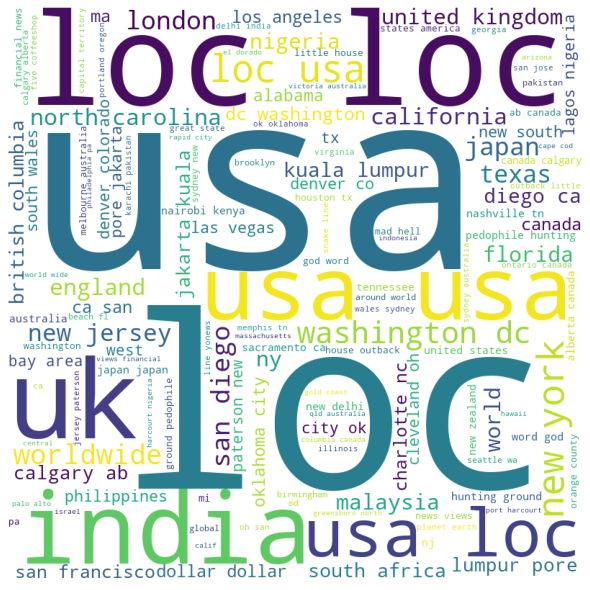

In [127]:
words = '' 
for val in data_raw_Disaster["location"]:
     val = str(val) 
  
    # split the value 
     tokens = val.split() 
      
    # Converts each token into lowercase 
     for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
        words += " ".join(tokens)+" "


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(words) 
  
# plot the location WordCloud image for disater tweets                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [128]:
data_train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [129]:
#balance data with equal no of disaster and non disaster tweets
data_raw_non_Disaster = data_train[data_train['target'] == 0]
data_raw_Disaster = data_train[data_train['target'] == 1]
diff=len(data_raw_non_Disaster)-len(data_raw_Disaster)    
data_sample=data_raw_Disaster.sample(round(diff/2),axis=0)
data_sample.shape

(536, 5)

In [130]:
nltk.download('wordnet')
temp_df = pd.DataFrame ( columns = data_train.columns)

#sequences = []
#targets = []

for index, row in data_sample.iterrows():
    seqs = []
    text = row['text']
    id=row['id']
    keyword=row['keyword']
    location=row['location']
    target=row['target']

    # if empty text, skipping to next row data
    if not text:
        continue

   # seqs.append(text)
    #temp_df.loc[len(temp_df.index)] = [id, keyword, location,text,target] 
    # apply data augmentation
    
    # random deletion
    seq2 = t.random_deletion(text, p=0.2)
    if type(seq2) == type([]):
        #seqs.append(seq2[0])
        temp_df.loc[len(temp_df.index)] = [id, keyword, location,seq2[0],target]
    else:
        #seqs.append(seq2)
        temp_df.loc[len(temp_df.index)] = [id, keyword, location,seq2,target]
        # random swap
    #if len(text) > 1:
      #  seq3=t.random_swap(text)
        #seqs.append(seq3)
      #  temp_df.loc[len(temp_df.index)] = [id, keyword, location,seq3,target]
    # synonym replacement and random insertion
    for i in range(2):
        seq4=t.synonym_replacement(text)
        #seqs.append(seq4) 
        temp_df.loc[len(temp_df.index)] = [id, keyword, location,seq4,target]
       # try:
         #   seq5=t.random_insertion(text)
         #   temp_df.loc[len(temp_df.index)] = [id, keyword, location,seq5,target]
            #seqs.append(seq5)
       # except:
         #   pass

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [131]:
data_train=pd.concat([data_train, temp_df],ignore_index=True)

data_raw_non_Disaster = data_train[data_train['target'] == 0]
data_raw_Disaster = data_train[data_train['target'] == 1]
print("Non Disatser Shape = "+str(data_raw_non_Disaster.shape))
print("Disaster Shape = "+str(data_raw_Disaster.shape))

Non Disatser Shape = (4342, 5)
Disaster Shape = (4879, 5)


In [132]:
length=len(data_raw_non_Disaster.index)
totalFrame = [data_raw_non_Disaster, data_raw_Disaster[:length]] #balanced dataframe
data_new = pd.concat(totalFrame)
data_new.sort_values('id', axis=0, ascending=True, inplace=True)
data_new.reset_index(drop = True, inplace = True)
data_new.to_csv(os.path.join(DATAPATH, TEMP_DF), index = False)
data_train = pd.read_csv(os.path.join(DATAPATH, TEMP_DF))
data_train.head()

,id,keyword,location,text,target
0,1,key,usa,our deeds are the reason of this earthquake ma...,1
1,4,fire,canada,forest fire near la ronge sask canada,1
2,5,evacuation,loc,all residents asked to shelter in place are be...,1
3,6,evacuation,usa,k people receive wildfires evacuation orders ...,1
4,7,smoke,usa,just got sent this photo from ruby alaska as s...,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of disaster tweets')

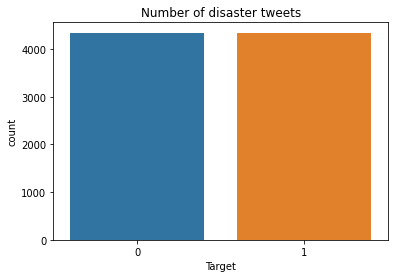

In [133]:
sns.countplot(data_train.target) #plot disaster and non disatser tweets
plt.xlabel('Target')
plt.title('Number of disaster tweets')

In [134]:
stop_words = set(stopwords.words('english'))  #stopwords for English
stemmer = SnowballStemmer("english")
def remove_stopwords(txt):
    word_list = word_tokenize(txt)
    no_stop_words = ' '.join(str(stemmer.stem(w)) for w in word_list if w not in stop_words and len(w)!=1)
    return no_stop_words

In [135]:
data_train['text'] = data_train['text'].apply(remove_stopwords)  #remove stopwords from tweet
def stem_words(w):
    return stemmer.stem(w)
data_train['keyword'] = data_train['keyword'].apply(stem_words)
data_train['location'] = data_train['location'].apply(stem_words)
data_train['combined_text']=data_train['location']+" "+data_train['keyword']+" "+data_train['text']  #combining location, keword and text feature
data_train['text_keword']=data_train['keyword']+" "+data_train['text']  #combining location, keword and text feature

In [136]:
data_train.head()

,id,keyword,location,text,target,combined_text,text_keword
0,1,key,usa,deed reason earthquak may allah forgiv us,1,usa key deed reason earthquak may allah forgiv us,key deed reason earthquak may allah forgiv us
1,4,fire,canada,forest fire near la rong sask canada,1,canada fire forest fire near la rong sask canada,fire forest fire near la rong sask canada
2,5,evacu,loc,resid ask shelter place notifi offic evacu she...,1,loc evacu resid ask shelter place notifi offic...,evacu resid ask shelter place notifi offic eva...
3,6,evacu,usa,peopl receiv wildfir evacu order california,1,usa evacu peopl receiv wildfir evacu order cal...,evacu peopl receiv wildfir evacu order california
4,7,smoke,usa,got sent photo rubi alaska smoke wildfir pour ...,1,usa smoke got sent photo rubi alaska smoke wil...,smoke got sent photo rubi alaska smoke wildfir...


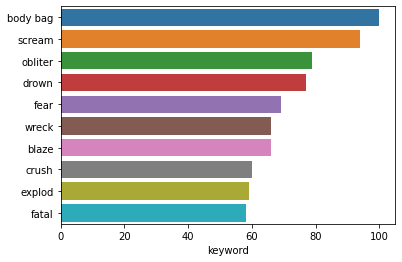

In [137]:
data_raw_non_Disaster = data_train[data_train['target'] == 0]
data_raw_Disaster = data_train[data_train['target'] == 1]
sns.barplot(y=data_raw_non_Disaster['keyword'].value_counts()[:10].index, #plot non disaster kewords
            x=data_raw_non_Disaster['keyword'].value_counts()[:10],
            orient='h');

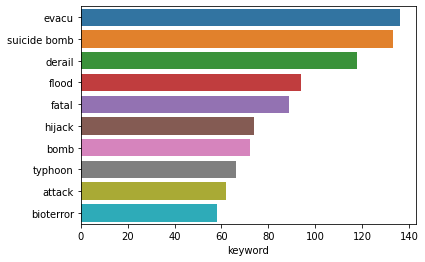

In [138]:
sns.barplot(y=data_raw_Disaster['keyword'].value_counts()[:10].index,  #plot disaster kewords
            x=data_raw_Disaster['keyword'].value_counts()[:10],
            orient='h');

In [149]:
X=data_train[['combined_text','text_keword']]
Y=data_train['target']
X_train_Temp, X_test_Temp, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=42)#split data for train and test
X_train_Temp, X_validation_Temp, Y_train, Y_validation = train_test_split(X_train_Temp, Y_train, test_size=0.2, 
                                                    random_state=42) #split data for train and validation
X_train=X_train_Temp[['combined_text']]
X_validation=X_validation_Temp[['combined_text']]
X_test=X_test_Temp[['combined_text']]
X_train.rename(columns = {'combined_text': 'text'}, inplace = True)
X_validation.rename(columns = {'combined_text': 'text'}, inplace = True)
X_test.rename(columns = {'combined_text': 'text'}, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


No we preprocess the data for training LSTM model and train the model

In [151]:
# tokenizer
Text_tokenizer = Tokenizer(num_words=max_words)  
# Updates internal vocabulary based on a list of texts. 
# This method creates the vocabulary index based on word frequency. 

train_text=X_train['text'].tolist()
validation_text=X_validation['text'].tolist()
test_text=X_test['text'].tolist()

Text_tokenizer.fit_on_texts(train_text)

# Transforms each row from texts to a sequence of integers. 
# So it basically takes each word in the text and replaces it 
train_text = Text_tokenizer.texts_to_sequences(train_text)
validation_text = Text_tokenizer.texts_to_sequences(validation_text)
test_text = Text_tokenizer.texts_to_sequences(test_text)


# Pad sequences
train_text = pad_sequences(train_text, maxlen=40, dtype='int32', 
                                           padding='pre', truncating='pre', value=0.)
validation_text = pad_sequences(validation_text, maxlen=40, dtype='int32', 
                                           padding='pre', truncating='pre', value=0.)
test_text = pad_sequences(test_text, maxlen=40, dtype='int32', 
                                           padding='pre', truncating='pre', value=0.)

text_word_index = Text_tokenizer.word_index


In [152]:
#convert dataframe to array
TrainFinal_RNN=np.array(train_text)
CVFinal_RNN=np.array(validation_text)
TestFinal_RNN=np.array(test_text)

TrainFinalLabels = Y_train
CVFinalLabels = Y_validation
TestFinalLabels = Y_test

TrainFinalLabels_RNN=np.array(TrainFinalLabels)
CVFinalLabels_RNN=np.array(CVFinalLabels)
TestFinalLabels_RNN=np.array(TestFinalLabels)


Create and Train the LSTM Model

In [153]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [154]:
#LSTM model
l2_reg = l2(0.001)
max_sequence_length = 40
model_file = 'model.h5'
num_classes = 2
embedding_size = 40
from tensorflow.keras.optimizers import Adam
def model_fn():
    model = Sequential()

    model.add(Embedding(max_words, embedding_size, input_length=max_sequence_length, embeddings_regularizer=l2_reg))
    
    model.add(SpatialDropout1D(0.5))
    
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2_reg, 
                   recurrent_regularizer=l2_reg, bias_regularizer=l2_reg))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(1024, activation='relu'))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(1024, activation='relu'))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(512, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    #optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    optimizer=Adam(learning_rate=0.0001, decay=1e-6)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    print(model.summary())

    return model

In [155]:
#training using LSTM

model_file = 'model.sav'

epochs = 100
batch_size = 128
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=5)
model = model_fn()

history = model.fit(TrainFinal_RNN, TrainFinalLabels_RNN,
          validation_data=(CVFinal_RNN, CVFinalLabels_RNN),
          epochs=epochs,
          batch_size=batch_size,
          shuffle=True,
          verbose=1,
          callbacks=[earlyStop])

# saving model
model.save(model_file)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 40)            160000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 40, 40)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                26880     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)             

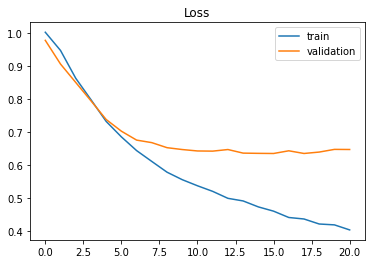

In [156]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show() #plot loss

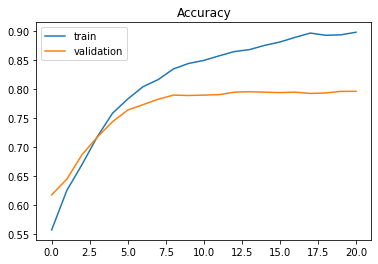

In [157]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()#plot accuracy

Now we preprocess the data and train XGBoost Model and SGD Model

In [158]:
def listOfListSent(TrainText):
    listOfSentences = []
    for sentence in TrainText.values:
        subSentence = []
        for word in sentence.split():
            subSentence.append(word)  
        listOfSentences.append(subSentence)
    return listOfSentences

In [159]:
# first create w2v feature only for question1 in the order train of question1 then cv of question1 then test of question1
# second create w2v feature only for question2 in the order train of question2 then cv of question2 then test of question2

def create_w2v(df, which_df, which_ques):
    listOfSentences = listOfListSent(df[which_ques])
    if which_df == "Train":
        # compute average word2vec for each text in train data.
        w2vModel = gensim.models.Word2Vec(listOfSentences, size=300, min_count=5, workers=4)
        pickle.dump(w2vModel, open(os.path.join(DATAPATH, "w2vModel.sav"), 'wb'))
        train_text_feature_w2v = []
        for sentence in listOfSentences:
            sentenceVector = np.zeros(300)
            TotalWordsPerSentence = 0
            for word in sentence:
                try:
                    vect = w2vModel.wv[word]
                    sentenceVector += vect
                    TotalWordsPerSentence += 1
                except:
                    pass
            if TotalWordsPerSentence!= 0:
                sentenceVector /= TotalWordsPerSentence
            train_text_feature_w2v.append(sentenceVector)
        return train_text_feature_w2v
    else:
        # compute average word2vec for each text in cv and test data.
        w2vModelLoaded = pickle.load(open(os.path.join(DATAPATH, "w2vModel.sav"), 'rb'))
        cv_test_text_feature_w2v = []
        for sentence in listOfSentences:
            sentenceVector = np.zeros(300)
            TotalWordsPerSentence = 0
            for word in sentence:
                try:
                    vect = w2vModelLoaded.wv[word]
                    sentenceVector += vect
                    TotalWordsPerSentence += 1
                except:
                    pass
            if TotalWordsPerSentence!= 0:
                sentenceVector /= TotalWordsPerSentence
            cv_test_text_feature_w2v.append(sentenceVector)
        return cv_test_text_feature_w2v

In [160]:
w2vFeaturesTrainText = create_w2v(X_train, "Train", "text")
w2vFeaturesCVText = create_w2v(X_validation, "CV", "text")
w2vFeaturesTestText = create_w2v(X_test, "Test", "text")

In [161]:
print("Shape of w2vFeaturesTrainText = {}".format(np.array(w2vFeaturesTrainText).shape))
print("Shape of w2vFeaturesCVText = {}".format(np.array(w2vFeaturesCVText).shape))
print("Shape of w2vFeaturesTestText = {}\n".format(np.array(w2vFeaturesTestText).shape))

Shape of w2vFeaturesTrainText = (5557, 300)
Shape of w2vFeaturesCVText = (1390, 300)
Shape of w2vFeaturesTestText = (1737, 300)



In [162]:
TrainFinal = np.array(w2vFeaturesTrainText)#final train data
TrainFinalLabels = Y_train
print("Shape of Train Data = {}".format(TrainFinal.shape))
print("Shape of Train Labels = {}\n".format(TrainFinalLabels.shape))
pickle.dump(TrainFinal, open(os.path.join(DATAPATH, 'TrainFinal.sav'), 'wb'))
pickle.dump(TrainFinalLabels, open(os.path.join(DATAPATH, 'TrainFinalLabels.sav'), 'wb'))

CVFinal = (np.array(w2vFeaturesCVText))
CVFinalLabels = Y_validation
print("Shape of CV Data = {}".format(CVFinal.shape))
print("Shape of CV Labels = {}\n".format(CVFinalLabels.shape))
pickle.dump(CVFinal, open(os.path.join(DATAPATH, 'CVFinal.sav'), 'wb'))
pickle.dump(CVFinalLabels, open(os.path.join(DATAPATH, 'CVFinalLabels.sav'), 'wb'))

TestFinal = (np.array(w2vFeaturesTestText))
TestFinalLabels = Y_test
print("Shape of CV Data = {}".format(TestFinal.shape))
print("Shape of CV Labels = {}\n".format(TestFinalLabels.shape))
pickle.dump(TestFinal, open(os.path.join(DATAPATH, 'TestFinal.sav'), 'wb'))
pickle.dump(TestFinalLabels, open(os.path.join(DATAPATH, 'TestFinalLabels.sav'), 'wb'))

Shape of Train Data = (5557, 300)
Shape of Train Labels = (5557,)

Shape of CV Data = (1390, 300)
Shape of CV Labels = (1390,)

Shape of CV Data = (1737, 300)
Shape of CV Labels = (1737,)



Train SGD SGDClassifier Model

For alpha value of 1e-05 CV log loss = 0.5850292868860308
For alpha value of 0.0001 CV log loss = 0.5769643871211914
For alpha value of 0.001 CV log loss = 0.5721415645519158
For alpha value of 0.01 CV log loss = 0.580805826288238
For alpha value of 0.1 CV log loss = 0.6038926700691818
For alpha value of 1 CV log loss = 0.6453882690504367
For alpha value of 10 CV log loss = 0.6869099501173282
For alpha value of 100 CV log loss = 0.6905324776188201


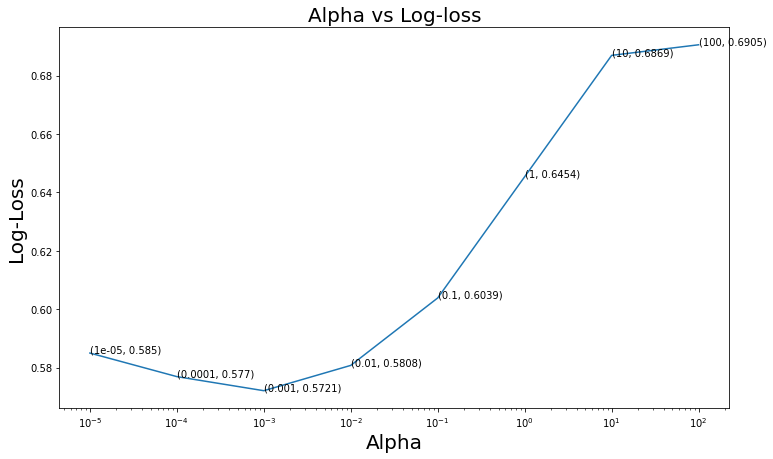

In [163]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Scalar = StandardScaler()
Scalar.fit(TrainFinal)
TrainFinalStd = Scalar.transform(TrainFinal)
CVFinalStd = Scalar.transform(CVFinal)

alpha = [10**x for x in range(-5, 3)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = "log", alpha = i)
    clf.fit(TrainFinalStd, TrainFinalLabels)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(TrainFinalStd, TrainFinalLabels)
    predicted_y = calib_clf.predict_proba(CVFinalStd)
    cv_log_loss.append(log_loss(CVFinalLabels, predicted_y))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CVFinalLabels, predicted_y))) #finding the best alpha for Stochastic Gradient Descent 

plt.figure(figsize = (12, 7))
plt.xscale('log')
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [164]:
#train sgd model
import seaborn as sns
import joblib
filename = 'sgdModel.sav'
Log_Loss = []
Accuracy_Scores = []
from sklearn.metrics.classification import accuracy_score, log_loss
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "log", alpha = best_alpha)
clf.fit(TrainFinalStd, TrainFinalLabels)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(TrainFinalStd, TrainFinalLabels)

joblib.dump(calib_clf, filename)

predict_val = calib_clf.predict_proba(CVFinalStd)

LR_LogLoss = log_loss(CVFinalLabels, predict_val)
LR_Accuracy = accuracy_score(CVFinalLabels, calib_clf.predict(CVFinalStd))
print('For values of best alpha = {}, Test LogLoss = {}, Test Accuracy Score = {}%'.format(best_alpha, LR_LogLoss, round((float(LR_Accuracy))*100,2)))

Log_Loss.append(LR_LogLoss)
Accuracy_Scores.append(LR_Accuracy)

For values of best alpha = 0.001, Test LogLoss = 0.5812066628359648, Test Accuracy Score = 71.44%


Train XGboost

In [165]:
#xgboost
import xgboost as xgb
filename = 'XGBoostModel.sav'
from sklearn.metrics.classification import accuracy_score, log_loss

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(TrainFinal, label=TrainFinalLabels)
d_test = xgb.DMatrix(CVFinal, label=CVFinalLabels)

watchlist = [(d_train, 'train'), (d_test, 'valid')]
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)
joblib.dump(bst, filename)

Log_Loss = []
Accuracy_Scores = []
d_test = xgb.DMatrix(CVFinal)
LR_LogLoss = log_loss(CVFinalLabels, bst.predict(d_test))
LR_Accuracy = accuracy_score(CVFinalLabels, list(map(lambda x: int(x>0.5), bst.predict(d_test))))
print('Test LogLoss = {}, Test Accuracy Score = {}%'.format(LR_LogLoss, round((float(LR_Accuracy))*100,2)))
Log_Loss.append(LR_LogLoss)
Accuracy_Scores.append(LR_Accuracy)

[0]	train-logloss:0.690705	valid-logloss:0.691138
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.669773	valid-logloss:0.674666
[20]	train-logloss:0.653448	valid-logloss:0.662537
[30]	train-logloss:0.64066	valid-logloss:0.653383
[40]	train-logloss:0.62894	valid-logloss:0.64517
[50]	train-logloss:0.618789	valid-logloss:0.638547
[60]	train-logloss:0.608886	valid-logloss:0.632274
[70]	train-logloss:0.600696	valid-logloss:0.627465
[80]	train-logloss:0.593048	valid-logloss:0.623314
[90]	train-logloss:0.58564	valid-logloss:0.618976
[100]	train-logloss:0.57917	valid-logloss:0.615657
[110]	train-logloss:0.5724	valid-logloss:0.61227
[120]	train-logloss:0.566217	valid-logloss:0.609321
[130]	train-logloss:0.559824	valid-logloss:0.606488
[140]	train-logloss:0.554097	valid-logloss:0.603442
[150]	train-logloss:0.54844	valid-logloss:0.600586
[160]	train-logloss:0.543986	valid-lo

Now Let's do a bit of Quality analysis on these models

In [166]:
from tensorflow import keras
xgboost_model= joblib.load('XGBoostModel.sav')
sgd_model = joblib.load('sgdModel.sav')
lstm_model =  keras.models.load_model('model.sav')

In [167]:
#method for printing confusion matrix
def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    # confusionMatx = [[1, 2],
    #                  [3, 4]]
    # confusionMatx.T = [[1, 3],
    #                   [2, 4]]
    # confusionMatx.sum(axis = 1)  axis=0 corresponds to columns and axis=1 corresponds to rows in two diamensional array
    # confusionMatx.sum(axix =1) = [[3, 7]]
    # (confusionMatx.T)/(confusionMatx.sum(axis=1)) = [[1/3, 3/7]
    #                                                  [2/3, 4/7]]

    # (confusionMatx.T)/(confusionMatx.sum(axis=1)).T = [[1/3, 2/3]
    #                                                    [3/7, 4/7]]
    # sum of row elements = 1
    plt.figure(figsize=(25, 7))
    labels = [0, 1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplot(1, 3, 2)
    sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Precision Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplot(1, 3, 3)
    sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Recall Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplots_adjust(wspace = 0.25)
    plt.show()
	

Printing confusion matrix for each Model

Test Accuracy Score = 71.68%


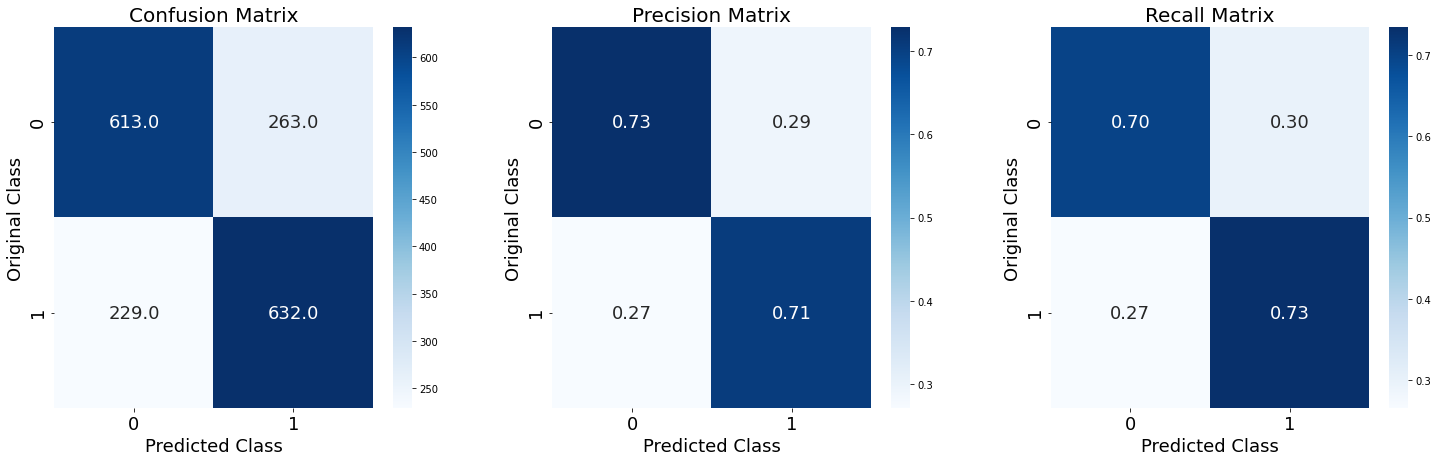

In [181]:
#print confusion matrix for XGDClassifier
TestFinalStd = Scalar.transform(TestFinal)
LR_Accuracy = accuracy_score(TestFinalLabels,sgd_model.predict(TestFinalStd))
print('Test Accuracy Score = {}%'.format(round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels, sgd_model.predict(TestFinalStd))

Test Accuracy Score = 69.03%


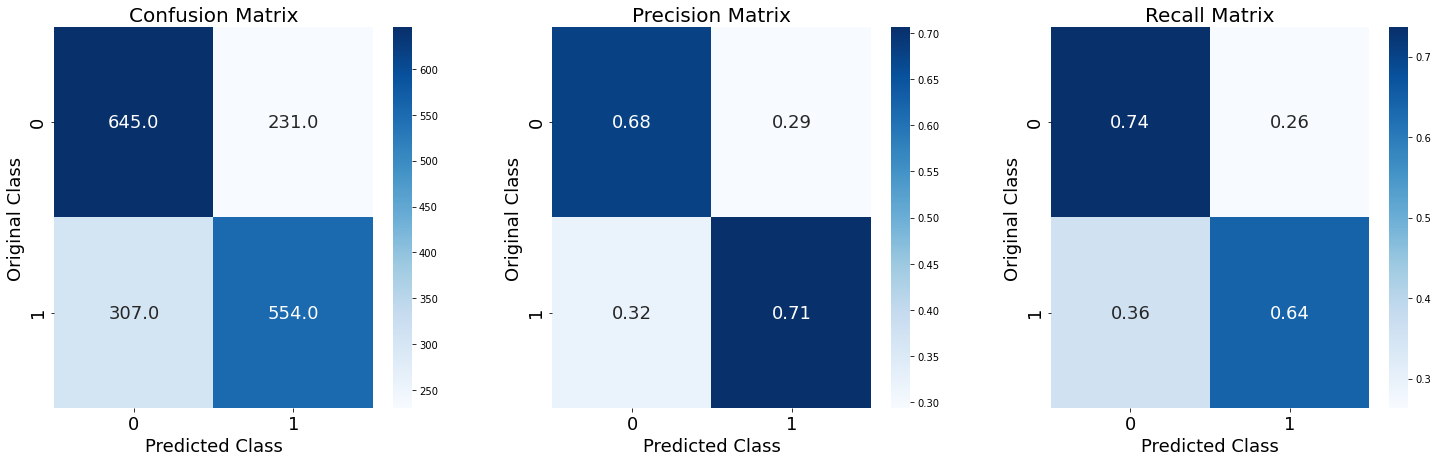

In [182]:
#Print confusion maxtrix for XGBoost
test = xgb.DMatrix(TestFinal, label=TestFinalLabels)
LR_Accuracy = accuracy_score(TestFinalLabels, list(map(lambda x: int(x>0.5), xgboost_model.predict(test))))
print('Test Accuracy Score = {}%'.format(round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels,  list(map(lambda x: int(x>0.5), xgboost_model.predict(test))) )

Test Accuracy Score = 79.74%


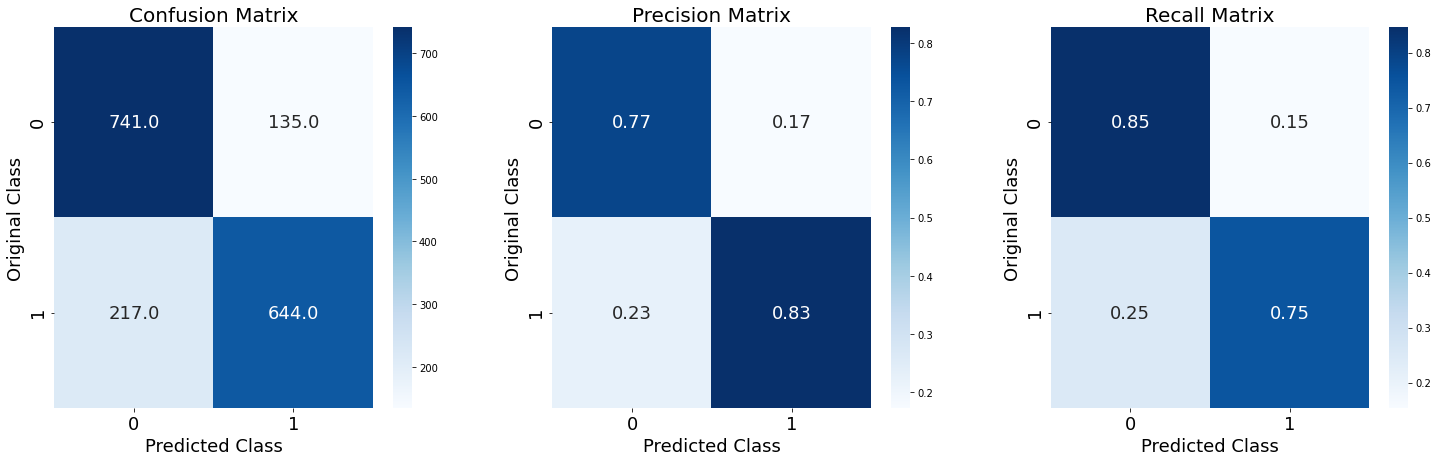

In [190]:
#Print confusion matrx for lstm
predicted = lstm_model.predict(TestFinal_RNN)
binary_predicted = np.array(predicted) >= 0.5
LR_Accuracy = accuracy_score(TestFinalLabels,  binary_predicted.astype(int).reshape((len(binary_predicted))))
print('Test Accuracy Score = {}%'.format(round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels,  binary_predicted.astype(int).reshape((len(binary_predicted))))

From Confusion Matrix the LSTM model OutPerforms the other two in terms of accuracy. Now lets see how consistent our models are. We will make some perturbations in our test data set and see how that affetcts the predictions

In [192]:
#Shuffle the words in X_test and see if that affects predictions
import random

def shuffle_words(sentence):
  words = sentence.split()
  random.shuffle(words)
  return  ' '.join(words)

X_test_new = pd.DataFrame(X_test['text'].apply(shuffle_words), columns = ['text'])

In [193]:
test_text_new=X_test_new['text'].tolist()
test_text_new = Text_tokenizer.texts_to_sequences(test_text_new)
test_text_new= pad_sequences(test_text_new, maxlen=40, dtype='int32', 
                                           padding='pre', truncating='pre', value=0.)
										   										   
Test_new_Final_RNN=np.array(test_text_new)


w2vFeaturesTest_new_Text = create_w2v(X_test_new, "Test", "text")
Test_new_Final = (np.array(w2vFeaturesTest_new_Text))


Let see the confusion matrix for the new test set. if the models are consistent the confusion matrix should be similar to that for initial predictions

Test Accuracy Score = 71.68%


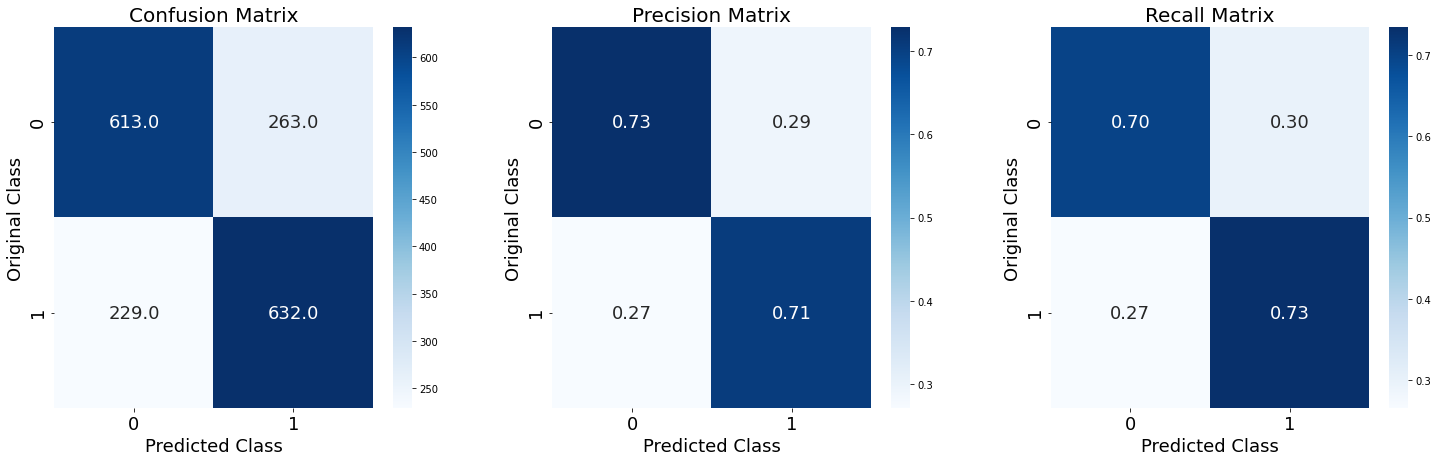

In [194]:
#print confusion matrix for XGDClassifier
TestNewFinalStd = Scalar.transform(Test_new_Final)
LR_Accuracy = accuracy_score(TestFinalLabels,sgd_model.predict(TestNewFinalStd))
print('Test Accuracy Score = {}%'.format(round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels, sgd_model.predict(TestNewFinalStd))

Test Accuracy Score = 69.03%


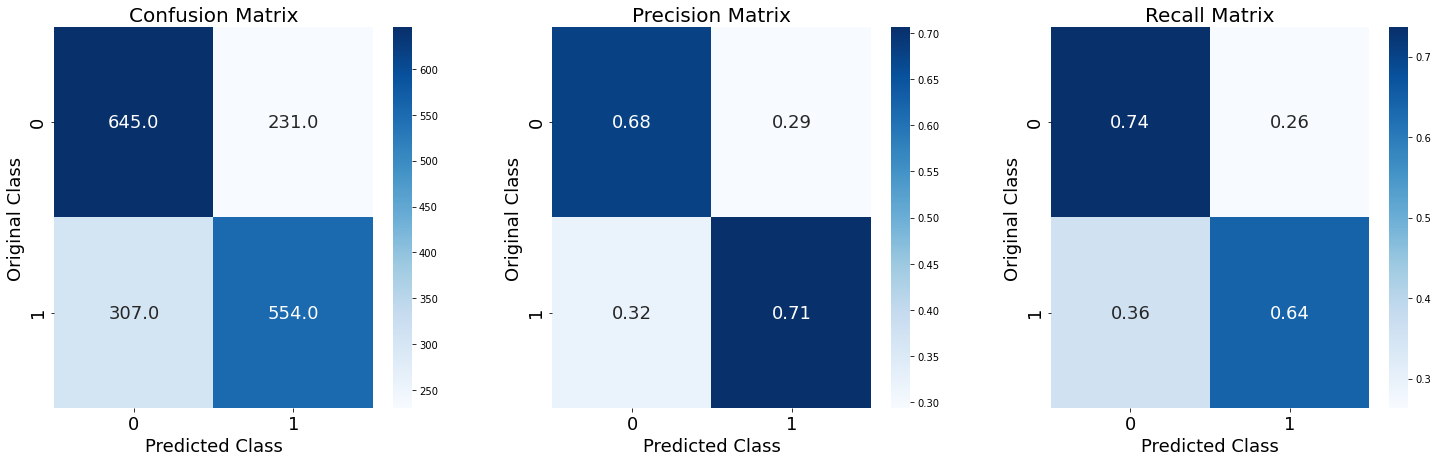

In [195]:
#Print confusion maxtrix for XGBoost
test = xgb.DMatrix(Test_new_Final, label=TestFinalLabels)
LR_Accuracy = accuracy_score(TestFinalLabels, list(map(lambda x: int(x>0.5), xgboost_model.predict(test))))
print('Test Accuracy Score = {}%'.format(round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels,  list(map(lambda x: int(x>0.5), xgboost_model.predict(test))) )

Test Accuracy Score = 79.85%


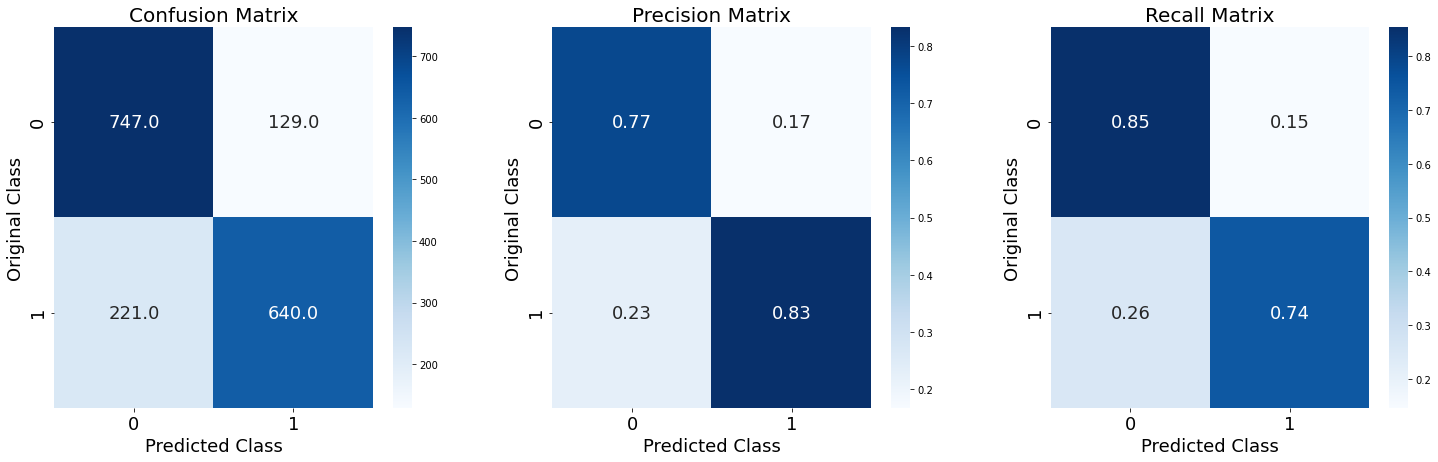

In [196]:
#Print confusion matrx for lstm
predicted = lstm_model.predict(Test_new_Final_RNN)
binary_predicted = np.array(predicted) >= 0.5
LR_Accuracy = accuracy_score(TestFinalLabels,  binary_predicted.astype(int).reshape((len(binary_predicted))))
print('Test Accuracy Score = {}%'.format(round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels,  binary_predicted.astype(int).reshape((len(binary_predicted))))

By comparing the confusion matrix for eahc model with confusion matrix before altering the test set we can see that the predictions of LSTM model is alightly increased when slight perturbations are presentnt in test set, while XGboost and SGD models are are fairly consitant. So consistency of LSTM model should be doubted.

Now Let's a how a feature has influenced each model. We will remove the location feature from test data and see if that influences predictions

In [197]:
X_test_new=X_test_Temp[['text_keword']]
X_test_new.rename(columns = {'text_keword': 'text'}, inplace = True)
test_text_new=X_test_new['text'].tolist()
test_text_new = Text_tokenizer.texts_to_sequences(test_text_new)
test_text_new= pad_sequences(test_text_new, maxlen=40, dtype='int32', 
                                           padding='pre', truncating='pre', value=0.)
										   										   
Test_new_Final_RNN=np.array(test_text_new)


w2vFeaturesTest_new_Text = create_w2v(X_test_new, "Test", "text")
Test_new_Final = (np.array(w2vFeaturesTest_new_Text))


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Test Accuracy Score = 70.75%


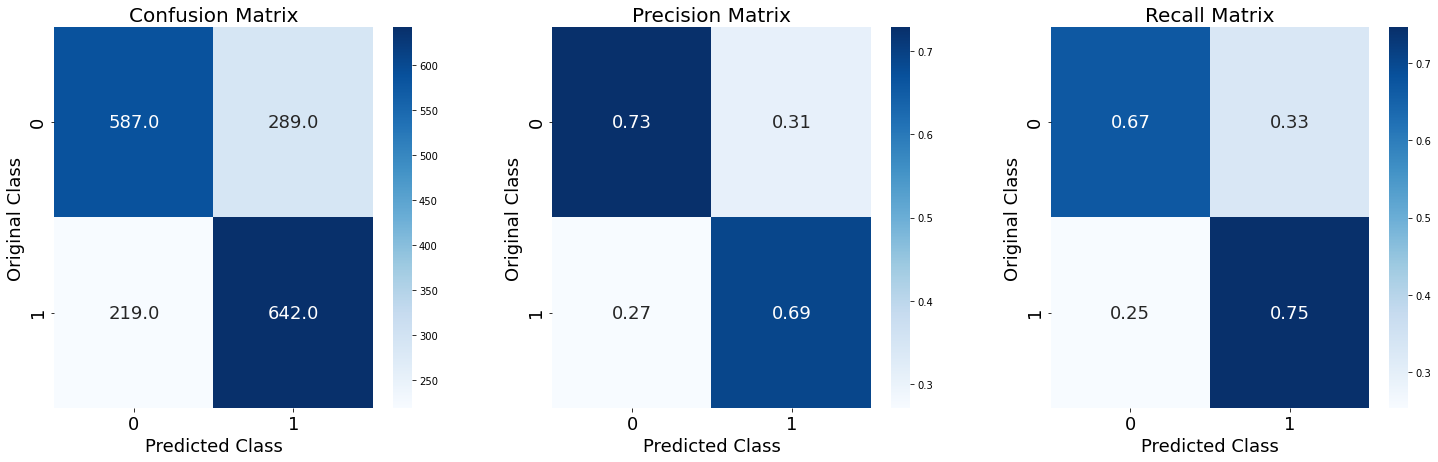

In [198]:
#print confusion matrix for XGDClassifier
TestNewFinalStd = Scalar.transform(Test_new_Final)
LR_Accuracy = accuracy_score(TestFinalLabels,sgd_model.predict(TestNewFinalStd))
print('Test Accuracy Score = {}%'.format(round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels, sgd_model.predict(TestNewFinalStd))

Test Accuracy Score = 66.67%


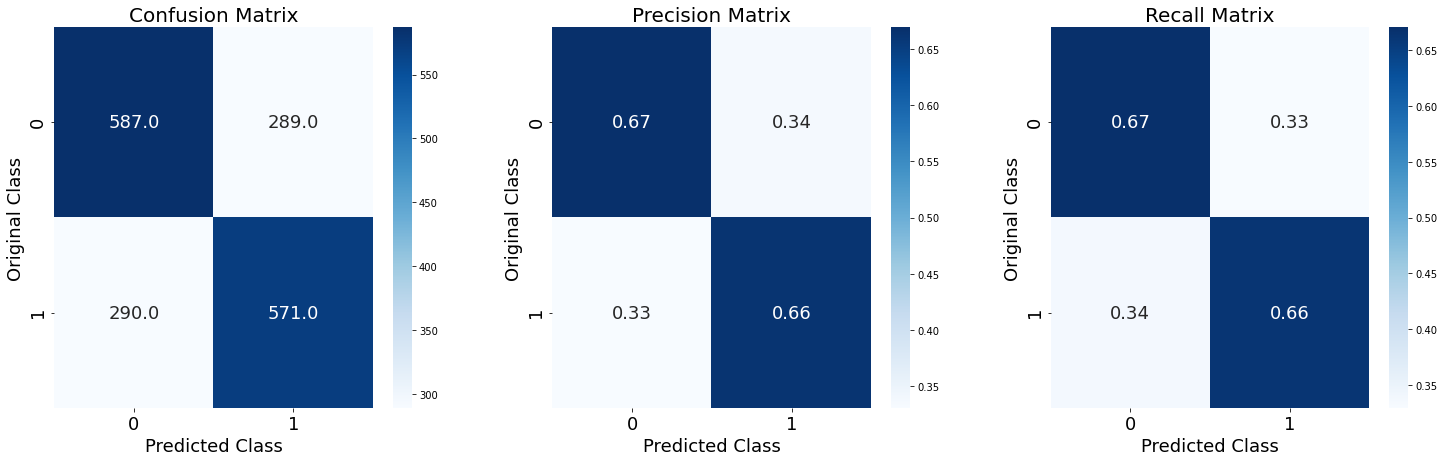

In [199]:
#Print confusion maxtrix for XGBoost
test = xgb.DMatrix(Test_new_Final, label=TestFinalLabels)
LR_Accuracy = accuracy_score(TestFinalLabels, list(map(lambda x: int(x>0.5), xgboost_model.predict(test))))
print('Test Accuracy Score = {}%'.format(round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels,  list(map(lambda x: int(x>0.5), xgboost_model.predict(test))) )

Test Accuracy Score = 79.33%


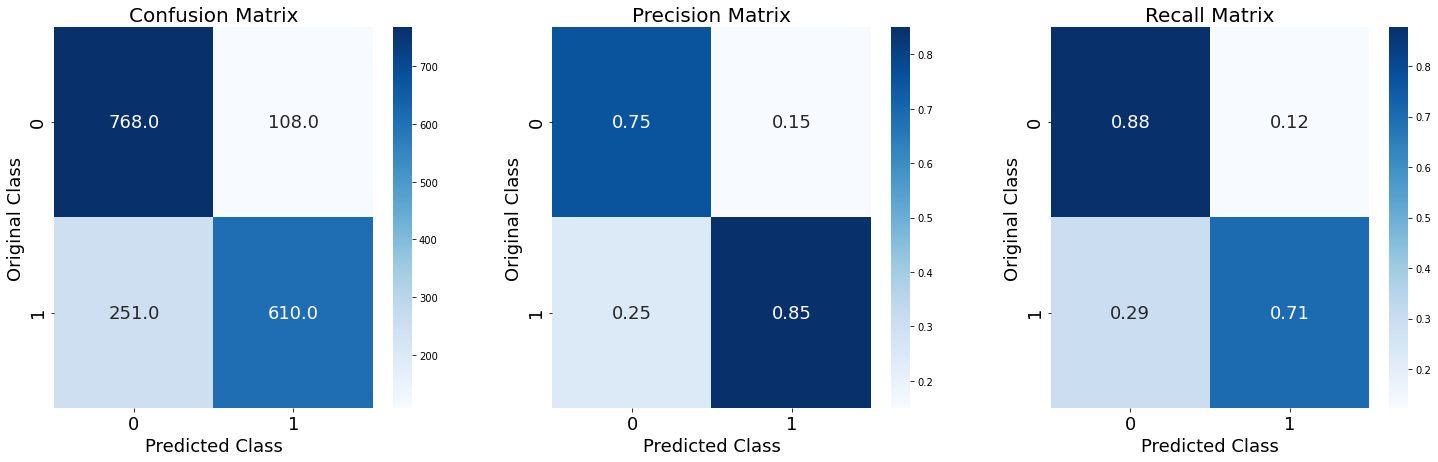

In [200]:
#Print confusion matrx for lstm
predicted = model.predict(Test_new_Final_RNN)
binary_predicted = np.array(predicted) >= 0.5
LR_Accuracy = accuracy_score(TestFinalLabels,  binary_predicted.astype(int).reshape((len(binary_predicted))))
print('Test Accuracy Score = {}%'.format(round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels,  binary_predicted.astype(int).reshape((len(binary_predicted))))

We would have expected the accuracy to go down for all the Models. But that is not actually the case. The accuracy of XGBoost model has gone down. but for SGD accuracy is almost the same and for LSTM the accuracy remains unchanged. So it is fair to rethink about the location feature in training the models since it's effect is negligible for LSTM and SGDclassifier

Now Let's see how our model prections are for some randomly generated combinations of String. Ideally if our models are any good all of these combinationse should be predicted as no disaster tweets(0)

In [223]:
# create data frame with random senetences
import string
import random
def random_sentence_generator():
  Sentence = ""
  for i in range(0,50): 
     letter = random.choice(string.ascii_letters)
     Sentence = Sentence+letter
  spaces=random.randint(4, 8)
  for i in range(0,spaces):
     loc =random.randint(0, 50)
     Sentence=Sentence[:loc] + " " + Sentence[loc:]
  return Sentence

test_df = pd.DataFrame(columns = ['text'])

for i in range(0, len(TestFinal)):
  test_df.loc[i]=random_sentence_generator()

test_df.head()

,text
0,tamkZNFpiMTQeJvWUtKNX a U dJWQi knIUPj Rnb Tbg...
1,W NoxtbJzthXLZv VGmrkiiu eCMvNGRJlZoOl AZpRm...
2,iCWh FhAsRfJS Aee WahvRCfSbp bgXAWpyYEnHWQUJ p...
3,ITbVimLOAQsEUXvosMrQq CWnBh hUlgE sDlkdIkf JH...
4,IV trXfKptPqqGU WfmecCr IGBAXQXXpSl TmQvGZXAb...


In [224]:
test_text_new=test_df['text'].tolist()
test_text_new = Text_tokenizer.texts_to_sequences(test_text_new)
test_text_new= pad_sequences(test_text_new, maxlen=40, dtype='int32', 
                                           padding='pre', truncating='pre', value=0.)
										   										   
Test_new_Final_RNN=np.array(test_text_new)


w2vFeaturesTest_new_Text = create_w2v(X_test_new, "Test", "text")
Test_new_Final = (np.array(w2vFeaturesTest_new_Text))

In [229]:
#see predictions for SGD Classifier
TestNewFinalStd = Scalar.transform(Test_new_Final)
y=np.bincount(sgd_model.predict(TestNewFinalStd))
ii=np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[  0, 806],
       [  1, 931]])

In [231]:
#see predictions for XGBoost
test = xgb.DMatrix(Test_new_Final)
y=np.bincount(list(map(lambda x: int(x>0.5), xgboost_model.predict(test))))
ii=np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[  0, 877],
       [  1, 860]])

In [232]:
#see predictions for LSTM
predicted = model.predict(Test_new_Final_RNN)
binary_predicted = np.array(predicted) >= 0.5
y=np.bincount(binary_predicted.astype(int).reshape((len(binary_predicted))))
ii=np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[   0, 1737]])

looks like XGBoost and SGDClassifier Models predect 860 and 931 disaster tweets respectively. But our LSTM model classified all the tweets as non Disaster tweets. So we can be pretty confident about our LSTM model